In [1]:
# Imports

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd


In [2]:
# Utility

def show_comparison(images, titles, figsize=(20, 5), cmap='gray'):
    """Show multiple images side by side."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    if n == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [3]:
# Frame Alignment

def show_comparison(images, titles, figsize=(20, 5), cmap='gray'):
    """Show multiple images side by side."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    if n == 1:
        axes = [axes]

    for ax, img, title in zip(axes, images, titles):
        if len(img.shape) == 3:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else:
            ax.imshow(img, cmap=cmap)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
# Iris Detection

def auto_detect_iris(img_bgr, expected_radius_range=(350, 450), visualize=False):
    """Detect iris using multiple edge methods + Hough circles."""
    if img_bgr is None:
        return None, None, None, 0.0

    h, w = img_bgr.shape[:2]
    green = img_bgr[:, :, 1]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(green)
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    adaptive = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 51, 2
    )
    _, otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    canny = cv2.Canny(blurred, 30, 100)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    edges = [adaptive, otsu, canny]

    all_circles = []
    min_r, max_r = expected_radius_range

    for edge in edges:
        morph = cv2.morphologyEx(edge, cv2.MORPH_CLOSE, kernel, iterations=2)
        morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel, iterations=1)
        morph = cv2.dilate(morph, kernel, iterations=1)

        for dp in [1.0, 1.2, 1.5]:
            for param2 in [15, 20, 30]:
                circles = cv2.HoughCircles(
                    morph, cv2.HOUGH_GRADIENT,
                    dp=dp, minDist=100,
                    param1=50, param2=param2,
                    minRadius=min_r, maxRadius=max_r
                )
                if circles is not None:
                    all_circles.extend(circles[0])

    if not all_circles:
        return None, None, None, 0.0

    expected_cx, expected_cy = w / 2, h / 2
    scored_circles = []

    for cx, cy, r in all_circles:
        cx, cy, r = int(cx), int(cy), int(r)
        dist = np.sqrt((cx - expected_cx)**2 + (cy - expected_cy)**2)
        center_score = 1 - min(dist / (w/4), 1)

        angles = np.linspace(0, 2*np.pi, 72, endpoint=False)
        edge_vals = []
        for a in angles:
            px, py = int(cx + r * np.cos(a)), int(cy + r * np.sin(a))
            if 0 <= px < w and 0 <= py < h:
                edge_vals.append(blurred[py, px])

        edge_score = (1 - np.std(edge_vals) / 128) if len(edge_vals) > 36 else 0
        score = 0.4 * center_score + 0.6 * edge_score
        scored_circles.append((cx, cy, r, score))

    best = max(scored_circles, key=lambda x: x[3])
    return best[0], best[1], best[2], best[3]


In [5]:
# Eyelash Removal

def simple_eyelash_removal(img_bgr, cx, cy, r,
                          top_cut_percentage=0.20,
                          bottom_cut_percentage=0.12,
                          visualize=False):
    """Circular mask + top/bottom horizontal cuts."""
    h, w = img_bgr.shape[:2]

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.circle(mask, (cx, cy), r, 255, -1)

    top_cut_pixels = int(r * top_cut_percentage)
    bottom_cut_pixels = int(r * bottom_cut_percentage)

    top_y = max(0, cy - r + top_cut_pixels)
    bottom_y = min(h, cy + r - bottom_cut_pixels)

    mask[:top_y, :] = 0
    mask[bottom_y:, :] = 0

    roi = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
    return roi, mask


In [6]:
# BUT Analysis helpers

def detect_black_threshold(first_frame, mask,
                           dark_percentile=3,
                           exclude_edges=True,
                           edge_margin=20):
    """Threshold = percentile of darkest pixels inside ROI mask."""
    h, w = first_frame.shape

    if exclude_edges:
        inner_mask = mask.copy()
        kernel = np.ones((edge_margin, edge_margin), np.uint8)
        inner_mask = cv2.erode(inner_mask, kernel, iterations=1)
    else:
        inner_mask = mask

    valid_pixels = first_frame[inner_mask > 0]
    if len(valid_pixels) == 0:
        return 0

    return np.percentile(valid_pixels, dark_percentile)

def build_evolution_curve(green_frames, masks, black_threshold,
                          remove_small_regions=True,
                          min_region_size=100,
                          use_morphology=True):
    """% breakup pixels per frame with cleaning."""
    n_frames = len(green_frames)
    evolution_curve = np.zeros(n_frames)

    for i, (frame, mask) in enumerate(zip(green_frames, masks)):
        black_map = ((frame < black_threshold) & (mask > 0)).astype(np.uint8)

        if use_morphology:
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
            black_map = cv2.morphologyEx(black_map, cv2.MORPH_OPEN, kernel)

        if remove_small_regions:
            num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(black_map, connectivity=8)
            cleaned_map = np.zeros_like(black_map)
            for label in range(1, num_labels):
                area = stats[label, cv2.CC_STAT_AREA]
                if area >= min_region_size:
                    cleaned_map[labels == label] = 1
            black_map = cleaned_map

        total_valid = np.sum(mask > 0)
        if total_valid > 0:
            evolution_curve[i] = (np.sum(black_map) / total_valid) * 100

    return evolution_curve

def fit_polynomial_curve(evolution_curve, poly_degree=2):
    """Fit polynomial to smooth curve."""
    n_frames = len(evolution_curve)
    x = np.arange(n_frames)
    coeffs = np.polyfit(x, evolution_curve, deg=poly_degree)
    fitted = np.polyval(coeffs, x)
    return fitted, coeffs

def detect_but_adaptive(fitted_curve,
                        base_percentage=40,
                        min_curve_height=3.0):
    """Adaptive BUT detection from fitted curve."""
    curve_min = np.min(fitted_curve)
    curve_max = np.max(fitted_curve)
    curve_height = curve_max - curve_min

    if curve_height < min_curve_height:
        return None, None

    slope = np.gradient(fitted_curve)
    max_slope = np.max(slope)

    if max_slope > 2.0:
        threshold_pct = base_percentage * 0.8
    else:
        threshold_pct = base_percentage * 1.2

    but_threshold = curve_min + (curve_height * threshold_pct / 100.0)
    crossing = np.where(fitted_curve > but_threshold)[0]
    but_frame = crossing[0] if len(crossing) > 0 else None

    return but_frame, but_threshold


In [7]:
# Frame Alignment Utilities 

def align_frame_to_reference(frame, ref_cx, ref_cy, curr_cx, curr_cy):
    """
    Translate frame so current iris center aligns with reference center.
    """
    h, w = frame.shape[:2]
    tx = ref_cx - curr_cx
    ty = ref_cy - curr_cy

    M = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)

    aligned = cv2.warpAffine(
        frame,
        M,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=0
    )

    return aligned


In [8]:
# Load Ground Truth

def load_ground_truth(data_file='dataset/data.txt'):
    """Load ground truth from data.txt (semicolon-separated)."""
    df = pd.read_csv(data_file, sep=';')
    gt_data = {}

    for _, row in df.iterrows():
        image_path = row['image']   # e.g. but1/but1_frame1440_breakup0.png
        breakup = row['breakup']

        parts = image_path.split('/')
        seq_name = parts[0]
        frame_name = parts[1]

        if seq_name not in gt_data:
            gt_data[seq_name] = {}

        gt_data[seq_name][frame_name] = breakup

    return gt_data


In [9]:
# Parameters

SEQUENCE_PARAMS = {
    'but1': {'top_cut': 0.60, 'bottom_cut': 0.00},
    'but2': {'top_cut': 0.00, 'bottom_cut': 0.05},
    'but3': {'top_cut': 0.55, 'bottom_cut': 0.20},
    'but4': {'top_cut': 0.30, 'bottom_cut': 0.12},
    'but5': {'top_cut': 0.60, 'bottom_cut': 0.12},
    'but6': {'top_cut': 0.60, 'bottom_cut': 0.12},
    'but7': {'top_cut': 0.60, 'bottom_cut': 0.05},
    'but8': {'top_cut': 0.60, 'bottom_cut': 0.12}
}

BUT_PARAMS = {
    'dark_percentile': 3,
    'but_threshold_pct': 50,
    'min_curve_height': 5.0,
    'min_region_size': 100
}


In [10]:
# Complete Processing Pipeline

def process_complete_sequence(seq_path, seq_params, seq_name, use_alignment=True):
    """Process one sequence folder (but1..but8)."""
    frames = sorted(list(seq_path.glob('*.png')))

    results = {
        'seq_name': seq_name,
        'originals': [],
        'aligned_frames': [],
        'detected_circles': [],
        'cropped_rois': [],
        'masks': [],
        'frame_names': [],
        'circle_params': [],
        'alignment_info': []
    }

    # Reference from first frame (for alignment)
    if use_alignment and len(frames) > 0:
        first_img = cv2.imread(str(frames[0]))
        ref_cx, ref_cy, ref_r, ref_score = auto_detect_iris(first_img, expected_radius_range=(350, 450))

        if ref_cx is None:
            print("  Warning: Could not detect iris in reference frame. Disabling alignment.")
            use_alignment = False
        else:
            results['reference'] = {'cx': ref_cx, 'cy': ref_cy, 'r': ref_r}

    # Process each frame
    for frame_idx, frame_path in enumerate(frames):
        img = cv2.imread(str(frame_path))
        fname = frame_path.name

        cx, cy, r, score = auto_detect_iris(img, expected_radius_range=(350, 450))
        if cx is None:
            continue

        aligned_img = img
        alignment_offset = {'tx': 0, 'ty': 0}

        if use_alignment:
            aligned_img = align_frame_to_reference(img, ref_cx, ref_cy, cx, cy)
            alignment_offset = {'tx': ref_cx - cx, 'ty': ref_cy - cy}

            aligned_cx, aligned_cy, aligned_r, aligned_score = auto_detect_iris(
                aligned_img, expected_radius_range=(350, 450)
            )

            if aligned_cx is not None:
                cx, cy, r, score = aligned_cx, aligned_cy, aligned_r, aligned_score
            else:
                cx, cy, r = ref_cx, ref_cy, ref_r

        # Circle visualization
        vis_circle = aligned_img.copy()
        cv2.circle(vis_circle, (cx, cy), r, (0, 255, 0), 3)
        cv2.circle(vis_circle, (cx, cy), 5, (0, 255, 0), -1)

        # Eyelash removal ROI
        roi, mask = simple_eyelash_removal(
            aligned_img, cx, cy, r,
            top_cut_percentage=seq_params['top_cut'],
            bottom_cut_percentage=seq_params['bottom_cut']
        )

        results['originals'].append(img)
        results['aligned_frames'].append(aligned_img)
        results['detected_circles'].append(vis_circle)
        results['cropped_rois'].append(roi)
        results['masks'].append(mask)
        results['frame_names'].append(fname)
        results['circle_params'].append({'cx': cx, 'cy': cy, 'r': r, 'score': score})

        results['alignment_info'].append({
            'frame_idx': frame_idx,
            'offset': alignment_offset
        })

    if len(results['aligned_frames']) == 0:
        print("  Error: No frames processed.")
        results['alignment_enabled'] = use_alignment
        return results

    # --- BUT analysis ---
    green_frames = []
    for aligned_img, mask in zip(results['aligned_frames'], results['masks']):
        green = aligned_img[:, :, 1]
        masked_green = cv2.bitwise_and(green, green, mask=mask)
        green_frames.append(masked_green)

    black_threshold = detect_black_threshold(
        green_frames[0], results['masks'][0],
        dark_percentile=BUT_PARAMS['dark_percentile']
    )

    evolution_curve = build_evolution_curve(
        green_frames, results['masks'], black_threshold,
        min_region_size=BUT_PARAMS['min_region_size']
    )

    fitted_curve, poly_coeffs = fit_polynomial_curve(evolution_curve)

    but_frame, but_threshold_val = detect_but_adaptive(
        fitted_curve,
        base_percentage=BUT_PARAMS['but_threshold_pct'],
        min_curve_height=BUT_PARAMS['min_curve_height']
    )

    results['but_analysis'] = {
        'black_threshold': black_threshold,
        'evolution_curve': evolution_curve,
        'fitted_curve': fitted_curve,
        'but_frame': but_frame,
        'but_threshold_val': but_threshold_val
    }

    results['alignment_enabled'] = use_alignment
    return results


In [11]:
# Process all sequences

dataset_path = Path('dataset')
ground_truth = load_ground_truth('dataset/data.txt')

all_sequence_results = {}

for seq_name in sorted(SEQUENCE_PARAMS.keys()):
    seq_path = dataset_path / seq_name

    if not seq_path.exists():
        print(f"Skipping {seq_name} (not found)")
        continue

    print(f"Processing {seq_name}...")

    results = process_complete_sequence(
        seq_path,
        SEQUENCE_PARAMS[seq_name],
        seq_name,
        use_alignment=True
    )

    all_sequence_results[seq_name] = results

print("Finished processing sequences:")
print(list(all_sequence_results.keys()))


Processing but1...
Processing but2...
Processing but3...
Processing but4...
Processing but5...
Processing but6...
Processing but7...
Processing but8...
Finished processing sequences:
['but1', 'but2', 'but3', 'but4', 'but5', 'but6', 'but7', 'but8']


In [12]:
# Generate Predictions

predictions = {}

for seq_name, results in all_sequence_results.items():
    predictions[seq_name] = {}

    but_analysis = results['but_analysis']
    fitted_curve = but_analysis['fitted_curve']
    but_threshold_val = but_analysis['but_threshold_val']

    for i, fname in enumerate(results['frame_names']):
        if but_threshold_val is None:
            predictions[seq_name][fname] = 0
        elif fitted_curve[i] > but_threshold_val:
            predictions[seq_name][fname] = 1
        else:
            predictions[seq_name][fname] = 0


In [13]:
# Evaluation

def evaluate_predictions(predictions, ground_truth):
    """Evaluate predictions against ground truth."""
    results = {
        'per_sequence': {},
        'overall': {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'correct': 0, 'total': 0}
    }

    for seq_name in ground_truth.keys():
        if seq_name not in predictions:
            continue

        seq_results = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0, 'correct': 0, 'total': 0}

        gt_frames = ground_truth[seq_name]
        pred_frames = predictions[seq_name]

        for frame_name, gt_label in gt_frames.items():
            if frame_name not in pred_frames:
                continue

            pred_label = pred_frames[frame_name]

            if gt_label == 1 and pred_label == 1:
                seq_results['tp'] += 1
                seq_results['correct'] += 1
            elif gt_label == 0 and pred_label == 0:
                seq_results['tn'] += 1
                seq_results['correct'] += 1
            elif gt_label == 0 and pred_label == 1:
                seq_results['fp'] += 1
            else:
                seq_results['fn'] += 1

            seq_results['total'] += 1

        # Update overall
        for key in ['tp', 'tn', 'fp', 'fn', 'correct', 'total']:
            results['overall'][key] += seq_results[key]

        # Metrics
        if seq_results['total'] > 0:
            seq_results['accuracy'] = (seq_results['correct'] / seq_results['total']) * 100
            seq_results['precision'] = seq_results['tp'] / (seq_results['tp'] + seq_results['fp']) if (seq_results['tp'] + seq_results['fp']) > 0 else 0
            seq_results['recall'] = seq_results['tp'] / (seq_results['tp'] + seq_results['fn']) if (seq_results['tp'] + seq_results['fn']) > 0 else 0
            seq_results['f1'] = (2 * seq_results['precision'] * seq_results['recall'] / (seq_results['precision'] + seq_results['recall'])
                                 if (seq_results['precision'] + seq_results['recall']) > 0 else 0)

        results['per_sequence'][seq_name] = seq_results

    overall = results['overall']
    if overall['total'] > 0:
        overall['accuracy'] = (overall['correct'] / overall['total']) * 100
        overall['precision'] = overall['tp'] / (overall['tp'] + overall['fp']) if (overall['tp'] + overall['fp']) > 0 else 0
        overall['recall'] = overall['tp'] / (overall['tp'] + overall['fn']) if (overall['tp'] + overall['fn']) > 0 else 0
        overall['f1'] = (2 * overall['precision'] * overall['recall'] / (overall['precision'] + overall['recall'])
                         if (overall['precision'] + overall['recall']) > 0 else 0)

    return results

eval_results = evaluate_predictions(predictions, ground_truth)


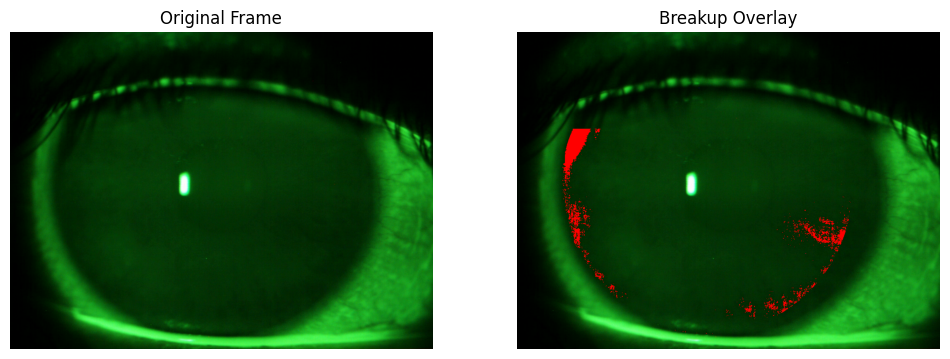

In [14]:
# Single frame visualization

DEMO_SEQUENCE = "but1"
DEMO_FRAME_NAME = "but1_frame1440_breakup0.png"

results = all_sequence_results[DEMO_SEQUENCE]
demo_idx = results["frame_names"].index(DEMO_FRAME_NAME)

but_analysis = results["but_analysis"]

img = results["originals"][demo_idx]
roi = results["cropped_rois"][demo_idx]
mask = results["masks"][demo_idx]

green = img[:, :, 1]
masked_green = cv2.bitwise_and(green, green, mask=mask)

black_map = ((masked_green < but_analysis["black_threshold"]) & (mask > 0)).astype(np.uint8)

overlay = img.copy()
overlay[black_map > 0] = [0, 0, 255]  # red in BGR

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Original Frame")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Breakup Overlay")
plt.axis("off")

plt.show()


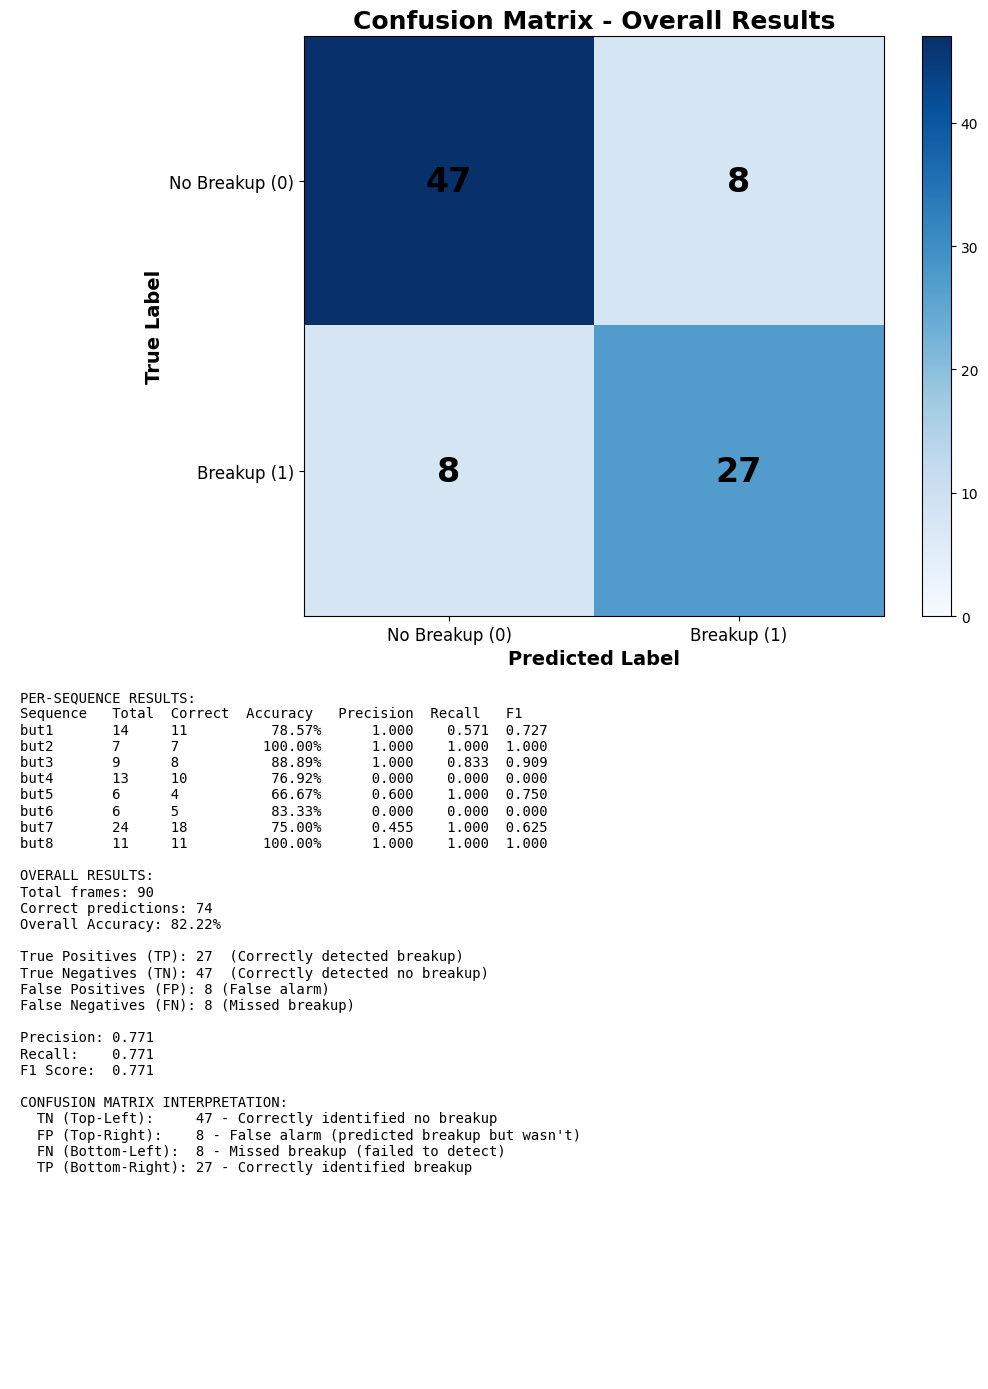

Saved: results_demo/final_confusion_and_results.png


In [15]:
# Saving results

SAVE_DIR = "results_demo"
os.makedirs(SAVE_DIR, exist_ok=True)

overall = eval_results['overall']
confusion = np.array([[overall['tn'], overall['fp']],
                      [overall['fn'], overall['tp']]])

# Build the text block (same style as your screenshot)
lines = []
lines.append("PER-SEQUENCE RESULTS:")
lines.append(f"{'Sequence':<10} {'Total':<6} {'Correct':<8} {'Accuracy':<10} {'Precision':<10} {'Recall':<8} {'F1':<6}")

for seq_name in sorted(eval_results['per_sequence'].keys()):
    s = eval_results['per_sequence'][seq_name]
    lines.append(f"{seq_name:<10} {s['total']:<6} {s['correct']:<8} {s['accuracy']:>8.2f}% "
                 f"{s['precision']:>10.3f} {s['recall']:>8.3f} {s['f1']:>6.3f}")

lines.append("")
lines.append("OVERALL RESULTS:")
lines.append(f"Total frames: {overall['total']}")
lines.append(f"Correct predictions: {overall['correct']}")
lines.append(f"Overall Accuracy: {overall['accuracy']:.2f}%")
lines.append("")
lines.append(f"True Positives (TP): {overall['tp']}  (Correctly detected breakup)")
lines.append(f"True Negatives (TN): {overall['tn']}  (Correctly detected no breakup)")
lines.append(f"False Positives (FP): {overall['fp']} (False alarm)")
lines.append(f"False Negatives (FN): {overall['fn']} (Missed breakup)")
lines.append("")
lines.append(f"Precision: {overall['precision']:.3f}")
lines.append(f"Recall:    {overall['recall']:.3f}")
lines.append(f"F1 Score:  {overall['f1']:.3f}")
lines.append("")
lines.append("CONFUSION MATRIX INTERPRETATION:")
lines.append(f"  TN (Top-Left):     {overall['tn']} - Correctly identified no breakup")
lines.append(f"  FP (Top-Right):    {overall['fp']} - False alarm (predicted breakup but wasn't)")
lines.append(f"  FN (Bottom-Left):  {overall['fn']} - Missed breakup (failed to detect)")
lines.append(f"  TP (Bottom-Right): {overall['tp']} - Correctly identified breakup")

text_block = "\n".join(lines)

# Create a single figure with matrix + text
fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(2, 1, height_ratios=[1.0, 1.2])

# Confusion matrix
ax0 = fig.add_subplot(gs[0])
im = ax0.imshow(confusion, cmap='Blues', vmin=0)
ax0.set_title("Confusion Matrix - Overall Results", fontsize=18, fontweight='bold')
ax0.set_xlabel("Predicted Label", fontsize=14, fontweight='bold')
ax0.set_ylabel("True Label", fontsize=14, fontweight='bold')
ax0.set_xticks([0, 1])
ax0.set_yticks([0, 1])
ax0.set_xticklabels(['No Breakup (0)', 'Breakup (1)'], fontsize=12)
ax0.set_yticklabels(['No Breakup (0)', 'Breakup (1)'], fontsize=12)

for i in range(2):
    for j in range(2):
        ax0.text(j, i, confusion[i, j], ha="center", va="center",
                 color="black", fontsize=24, fontweight='bold')

fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)

# Text block
ax1 = fig.add_subplot(gs[1])
ax1.axis("off")
ax1.text(0.01, 0.99, text_block, va="top", ha="left", family="monospace", fontsize=10)

plt.tight_layout()
out_path = f"{SAVE_DIR}/final_confusion_and_results.png"
plt.savefig(out_path, dpi=300)
plt.show()

print(f"Saved: {out_path}")
